##  Categorical Data

In [1]:
import pandas as pd
import numpy as np

Frequently, a column in a table may contain repeated instances of a smaller set of distinct values. 

We have already seen functions like `unique` and `value_counts`, which enable us to extract the distinct values from an array and compute their frequencies, respectively:

In [2]:
values = pd.Series(["apple", "orange", "apple", "apple"] * 2)

In [3]:
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [4]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [5]:
values.value_counts()

apple     6
orange    2
dtype: int64

Many data systems (for data warehousing, statistical computing, or other uses) have developed specialized approaches for **representing data with repeated values for more efficient storage and computation**. 

In data warehousing, the best practice is to use so called *dimension tables* containing the distinct values and *storing the primary observations as integer keys* referencing the dimension table:

In [6]:
values = pd.Series([0, 1, 0, 0] * 2)

In [7]:
dim = pd.Series(["apple", "orange"])

In [8]:
values

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64

In [9]:
dim

0     apple
1    orange
dtype: object

We can use the `take` method to restore the original Series of strings:

In [10]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

This representation as integers is called the **categorical** or **dictionary-encoded** representation. The array of distinct values can be called the *categories*, *dictionary*, or *levels of the data*. We will use the terms *categorical* and *categories*. The integer values that reference the categories are called the *category codes* or simply *codes*.

The categorical representation can yield significant performance improvements when you are doing analytics. You can also perform **transformations on the categories** while leaving the codes unmodified. Some example transformations that can be made at relatively low cost are:



* Renaming categories
* Appending a new category without changing the order or position of the existing categories

### Categorical Type in pandas

pandas has a special `Categorical` type for holding data that uses the integer-based categorical representation or *encoding*. Let’s consider the example Series from before:

In [11]:
fruits = ["apple", "orange", "apple", "apple"] * 2

In [12]:
N = len(fruits)

In [13]:
df = pd.DataFrame(
    {
        "fruit": fruits,
        "basket_id": np.arange(N),
        "count": np.random.randint(3, 15, size=N),
        "weight": np.random.uniform(0, 4, size=N),
    },
    columns=["basket_id", "fruit", "count", "weight"],
)

In [14]:
df

,basket_id,fruit,count,weight
0,0,apple,3,1.217769
1,1,orange,10,2.356987
2,2,apple,12,3.552770
3,3,apple,14,2.013967
4,4,apple,8,3.744619
5,5,orange,12,2.246895
6,6,apple,4,2.665832
7,7,apple,7,0.420211


Here, `df['fruit']` is an array of Python string objects. We can convert it to categorical by calling

In [15]:
fruit_cat = df["fruit"].astype("category")

In [16]:
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

The values for `fruit_cat` are not a NumPy array, but an instance of `pandas.Categorical`:

In [17]:
c = fruit_cat.values

In [18]:
c

['apple', 'orange', 'apple', 'apple', 'apple', 'orange', 'apple', 'apple']
Categories (2, object): ['apple', 'orange']

In [19]:
type(c)

pandas.core.arrays.categorical.Categorical

The `Categorical` object has `categories` and `codes` attributes:

In [20]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [21]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

You can convert a DataFrame column to categorical by assigning the converted result:

In [22]:
df["fruit"] = df["fruit"].astype("category")

In [23]:
df["fruit"]

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

You can also create `pandas.Categorical` directly from other types of Python sequences:

In [24]:
my_categories = pd.Categorical(["foo", "bar", "baz", "foo", "bar"])

In [25]:
my_categories

['foo', 'bar', 'baz', 'foo', 'bar']
Categories (3, object): ['bar', 'baz', 'foo']

In [26]:
my_categories.codes

array([2, 0, 1, 2, 0], dtype=int8)

If you have obtained categorical encoded data from another source, you can use the alternative `from_codes` constructor:

In [27]:
categories = ["foo", "bar", "baz"]

In [28]:
codes = [0, 1, 2, 0, 0, 1]

In [29]:
my_cats_2 = pd.Categorical.from_codes(codes, categories)

In [30]:
my_cats_2

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo', 'bar', 'baz']

In [31]:
my_cats_2

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo', 'bar', 'baz']

Unless explicitly specified, categorical conversions assume *no specific ordering of the categories*. So the categories array may be in a different order **depending on the ordering of the input data**. When using `from_codes` or any of the other constructors,
you can indicate that the categories have a meaningful ordering:

In [32]:
ordered_cat = pd.Categorical.from_codes(codes, categories, ordered=True)

In [33]:
ordered_cat

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

The output [foo < bar < baz] indicates that 'foo' precedes 'bar' in the ordering, and so on. An unordered categorical instance can be made ordered with `as_ordered`:

In [34]:
my_cats_2.as_ordered()

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

As a last note, categorical data *need not be strings*. A categorical array can consist of *any immutable value types*.

## Computations with Categoricals

Using `Categorical` in pandas compared with the non-encoded version (like an array of strings) generally behaves the same way. Some parts of pandas, like the `groupby` function, *perform better* when working with categoricals. There are also some functions that can utilize the ordered flag.

Let’s consider some random numeric data, and use the `pandas.qcut` binning function. This returns `pandas.Categorical`; we used `pandas.cut` earlier but glossed over the details of how categoricals work:

In [35]:
np.random.seed(12345)

In [36]:
draws = np.random.randn(1000)

In [37]:
draws[:5]

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057])

Let’s compute a quartile binning of this data and extract some statistics:

In [38]:
bins = pd.qcut(draws, 4)  # find bin of each number

In [39]:
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64, right]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] < (0.63, 3.928]]

In [40]:
bins.categories

IntervalIndex([(-2.9499999999999997, -0.684], (-0.684, -0.0101], (-0.0101, 0.63], (0.63, 3.928]], dtype='interval[float64, right]')

In [41]:
len(bins)

1000

While useful, the exact sample quartiles may be less useful for producing a report than quartile names. We can achieve this with the labels argument to qcut:

In [42]:
bins = pd.qcut(draws, 4, labels=["Q1", "Q2", "Q3", "Q4"])

In [43]:
bins

['Q2', 'Q3', 'Q2', 'Q2', 'Q4', ..., 'Q3', 'Q2', 'Q1', 'Q3', 'Q4']
Length: 1000
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

In [44]:
bins.codes[:10]

array([1, 2, 1, 1, 3, 3, 2, 2, 3, 3], dtype=int8)

The labeled bins categorical does not contain information about the *bin edges* in the data, so we can use `groupby` to extract some summary statistics:

In [45]:
bins = pd.Series(bins, name="quartile")

In [46]:
bins

0      Q2
1      Q3
2      Q2
3      Q2
4      Q4
       ..
995    Q3
996    Q2
997    Q1
998    Q3
999    Q4
Name: quartile, Length: 1000, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

In [47]:
results = pd.Series(draws).groupby(bins).agg(["count", "min", "max"]).reset_index()

In [48]:
results

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


The `quartile` column in the result retains the original categorical information, including ordering, from bins:

In [49]:
results["quartile"]

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

### Better performance with categoricals

If you do a lot of analytics on a particular dataset, converting to categorical can yield substantial overall performance gains. A categorical version of a DataFrame column will often use significantly less memory, too. Let’s consider some Series with 10 million elements and a small number of distinct categories:

In [50]:
N = 10000000

In [51]:
draws = pd.Series(np.random.randn(N))

In [52]:
draws[:10]

0   -0.983505
1    0.930944
2   -0.811676
3   -1.830156
4   -0.138730
5    0.334088
6    0.488675
7   -0.178098
8    2.122315
9    0.061192
dtype: float64

In [53]:
labels = pd.Series(["foo", "bar", "baz", "qux"] * (N // 4))

In [54]:
labels

0          foo
1          bar
2          baz
3          qux
4          foo
          ... 
9999995    qux
9999996    foo
9999997    bar
9999998    baz
9999999    qux
Length: 10000000, dtype: object

Now we convert `labels` to categorical:

In [55]:
categories = labels.astype("category")

In [56]:
labels.memory_usage()

80000128

In [57]:
categories.memory_usage()

10000332

The conversion to category is not free, of course, but it is a one-time cost:

In [58]:
%time _ = labels.astype('category')

CPU times: user 484 ms, sys: 72.4 ms, total: 557 ms
Wall time: 555 ms


GroupBy operations can be significantly faster with categoricals because the underlying algorithms use the integer-based codes array instead of an array of strings.

## Categorical Methods

Series containing categorical data have several special methods similar to the `Series.str` specialized string methods. This also provides convenient access to the categories and codes. Consider the Series:

In [59]:
s = pd.Series(["a", "b", "c", "d"] * 2)

In [60]:
cat_s = s.astype("category")

In [61]:
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

The special attribute cat provides access to categorical methods:

In [62]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [63]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

Suppose that we know the actual set of categories for this data extends beyond the four values observed in the data. We can use the `set_categories` method to change them:

In [64]:
actual_categories = ["a", "b", "c", "d", "e"]

In [65]:
cat_s2 = cat_s.cat.set_categories(actual_categories)

In [66]:
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

While it appears that *the data is unchanged*, the new categories will be reflected in operations that use them. For example, `value_counts` respects the categories, if present:

In [67]:
cat_s.value_counts()

a    2
b    2
c    2
d    2
dtype: int64

In [68]:
cat_s2.value_counts()

a    2
b    2
c    2
d    2
e    0
dtype: int64

In large datasets, categoricals are often used as a convenient tool for memory savings and better performance. 

After you filter a large DataFrame or Series, many of the categories may not appear in the data. To help with this, we can use the `remove_unused_categories` method to trim unobserved categories:

In [69]:
cat_s3 = cat_s[cat_s.isin(["a", "b"])]

In [70]:
cat_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

In [71]:
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): ['a', 'b']

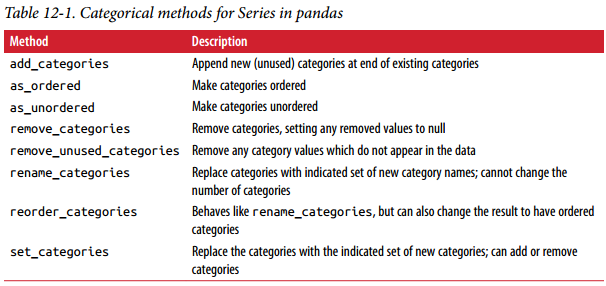

## Creating dummy variables for modeling

When you're using statistics or machine learning tools, you'll often transform categorical data into **dummy variables**, also known as **one-hot encoding**. This involves *creating a DataFrame with a column for each distinct category*; these columns contain 1's for occurrences of a given category and 0 otherwise.

Consider the previous example:

In [72]:
cat_s = pd.Series(["a", "b", "c", "d"] * 2, dtype="category")

The `pandas.get_dummies` function converts this one-dimensional categorical data into a DataFrame containing the dummy
variable:

In [73]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


## Advanced GroupBy

Please see the `7-Data Aggregation and Group Operations` section to get familiar with Grouping Operations basics in pandas.

### Group Transforms and “Unwrapped” GroupBys

We looked at the `apply` method in grouped operations for performing transformations. There is another built-in method called `transform`, which is similar to `apply` but imposes more constraints on the kind of function you can use:

* It can produce a scalar value to be broadcast to the shape of the group
* It can produce an object of the same shape as the input group
* It must not mutate its input

[More details on apply(), applymap(), transform()](http://www.sefidian.com/2022/06/23/a-tutorial-on-pandas-apply-applymap-map-and-transform/)

In [74]:
df = pd.DataFrame({"key": ["a", "b", "c"] * 4, "value": np.arange(12.0)})

In [75]:
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


Here are the group means by key:

In [76]:
g = df.groupby("key")["value"]

In [77]:
g

In [78]:
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

Suppose instead we wanted to produce a Series of the same shape as `df['value']` but with values replaced by the average grouped by 'key'. We can pass the function `lambda x: x.mean()` to `transform`:

In [79]:
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [80]:
df.groupby("key")

In [81]:
df.groupby("key").mean()

,value
key,
a,4.5
b,5.5
c,6.5


In [82]:
df.groupby("key").transform(lambda x: x.mean())

,value
0,4.5
1,5.5
2,6.5
3,4.5
4,5.5
5,6.5
6,4.5
7,5.5
8,6.5
9,4.5


In [83]:
g.transform("mean")

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

Like `apply`, `transform` works with functions that return Series, but *the result must be the same size as the input*. For example, we can multiply each group by 2 using a lambda function:

In [84]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

As a more complicated example, we can compute the ranks in descending order for each group:

In [85]:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

Consider a group transformation function composed from simple aggregations:

In [86]:
def normalize(x):
    return (x - x.mean()) / x.std()

We can obtain equivalent results in this case either using `transform` or `apply`:

In [87]:
g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [88]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

Built-in aggregate functions like 'mean' or 'sum' are often much faster than a general `apply` function. These also have a “fast past” when used with `transform`. This allows us to perform a so-called unwrapped group operation:

In [89]:
g.transform("mean")

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [90]:
normalized = (df["value"] - g.transform("mean")) / g.transform("std")

In [91]:
normalized

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

While an unwrapped group operation may involve multiple group aggregations, the overall benefit of vectorized operations often outweighs this.

### Grouped Time Resampling

For time series data, the `resample` method is semantically a group operation based on a time intervalization. Here’s a small example table:

In [92]:
N = 15
times = pd.date_range("2017-05-20 00:00", freq="1min", periods=N)
df = pd.DataFrame({"time": times, "value": np.arange(N)})

In [93]:
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


Here, we can index by 'time' and then resample:

In [96]:
df.set_index("time").resample("5min").count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


Suppose that a DataFrame contains multiple time series, marked by an additional group key column:

In [97]:
df2 = pd.DataFrame(
    {
        "time": times.repeat(3),
        "key": np.tile(["a", "b", "c"], N),
        "value": np.arange(N * 3.0),
    }
)

In [100]:
df2.tail(10)

,time,key,value
35,2017-05-20 00:11:00,c,35.0
36,2017-05-20 00:12:00,a,36.0
37,2017-05-20 00:12:00,b,37.0
38,2017-05-20 00:12:00,c,38.0
39,2017-05-20 00:13:00,a,39.0
40,2017-05-20 00:13:00,b,40.0
41,2017-05-20 00:13:00,c,41.0
42,2017-05-20 00:14:00,a,42.0
43,2017-05-20 00:14:00,b,43.0
44,2017-05-20 00:14:00,c,44.0


To do the same resampling for each value of 'key', we introduce the `pandas.TimeGrouper` object:

In [103]:
time_key = pd.Grouper(freq="5min")

We can then set the time index, group by 'key' and `time_key`, and aggregate:

In [104]:
resampled = df2.set_index("time").groupby(["key", time_key]).sum()

In [105]:
resampled

value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0

In [106]:
resampled.reset_index()

,key,time,value
0,a,2017-05-20 00:00:00,30.0
1,a,2017-05-20 00:05:00,105.0
2,a,2017-05-20 00:10:00,180.0
3,b,2017-05-20 00:00:00,35.0
4,b,2017-05-20 00:05:00,110.0
5,b,2017-05-20 00:10:00,185.0
6,c,2017-05-20 00:00:00,40.0
7,c,2017-05-20 00:05:00,115.0
8,c,2017-05-20 00:10:00,190.0


One constraint with using `Grouper` is that the time must be the index of the Series or DataFrame.

## Techniques for Method Chaining

When applying a sequence of transformations to a dataset, you may find yourself creating numerous temporary variables that are never used in your analysis. Consider this example, for instance:

```python
df = load_data()
df2 = df[df["col2"] < 0]
df2["col1_demeaned"] = df2["col1"] - df2["col1"].mean()
result = df2.groupby("key").col1_demeaned.std()
```

While we’re not using any real data here, this example highlights some new methods. First, the `DataFrame.assign` method is a **functional alternative** to column assignments of the form `df[k] = v`. Rather than modifying the object in-place, it *returns a new DataFrame* with the indicated modifications. So these statements are equivalent:

```python
# Usual non-functional way
df2 = df.copy()
df2["k"] = v

# Functional assign way
df2 = df.assign(k=v)
```

Assigning in-place may execute faster than using `assign`, but assign enables *easier method chaining*:

```python
result = (df2.assign(col1_demeaned=df2.col1 - df2.col2.mean())
          .groupby('key')
          .col1_demeaned.std())
```

One thing to keep in mind when doing method chaining is that you may need to *refer to temporary objects*. In the preceding example, we cannot refer to the result of `load_data` until it has been assigned to the temporary variable `df`. To help with this, `assign` and many other pandas functions accept function-like arguments, also known as **callables**.

To show callables in action, consider a fragment of the example from before:

```python
df = load_data()
df2 = df[df["col2"] < 0]
```

This can be rewritten as:

```python
df = load_data()[lambda x: x["col2"] < 0]
```

Here, the result of `load_data` is not assigned to a variable, so the function passed into [] is then **bound** to the object at that stage of the method chain.

We can continue, then, and write the entire sequence as a single chained expression:

```python
result = (
    load_data()[lambda x: x.col2 < 0]
    .assign(col1_demeaned=lambda x: x.col1 - x.col1.mean())
    .groupby("key")
    .col1_demeaned.std()
)
```

### The pipe Method
Please see [this link](http://www.sefidian.com/2021/11/12/making-data-pipelines-in-pandas-using-pipe-method/) for more details.

You can accomplish a lot with *built-in pandas functions* and the approaches to method chaining with callables that we just looked at. However, sometimes you need to *use your own functions* or functions from third-party libraries. This is where the `pipe` method comes in.

Consider a sequence of function calls:

```python
a = f(df, arg1=v1)
b = g(a, v2, arg3=v3)
c = h(b, arg4=v4)
```

When using functions that accept and return Series or DataFrame objects, you can rewrite this using calls to `pipe`:

```python
result = df.pipe(f, arg1=v1).pipe(g, v2, arg3=v3).pipe(h, arg4=v4)
```

The statement `f(df)` and `df.pipe(f)` are equivalent, but pipe makes chained invocation easier.

A potentially useful pattern for `pipe` is to generalize sequences of operations into reusable functions. As an example, let’s consider *substracting group means from a column*:

```python
g = df.groupby(["key1", "key2"])
df["col1"] = df["col1"] - g.transform("mean")
```

Suppose that you wanted to be able to demean more than one column and easily change the group keys. Additionally, you might want to perform this transformation in a method chain. Here is an example implementation:

In [108]:
def group_demean(df, by, cols):
    result = df.copy()
    g = df.groupby(by)
    for c in cols:
        result[c] = df[c] - g[c].transform("mean")
    return result

Then it is possible to write:

```python
result = df[df.col1 < 0].pipe(group_demean, ["key1", "key2"], ["col1"])
```

## Continuing Your Education
* Introduction to Machine Learning with Python by Andreas Mueller and Sarah Guido (O’Reilly)
* Python Data Science Handbook by Jake VanderPlas (O’Reilly)
* Data Science from Scratch: First Principles with Python by Joel Grus (O’Reilly)
* Python Machine Learning by Sebastian Raschka (Packt Publishing)
* Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron (O’Reilly)